# Decouple timesteps from amount of paramters. We use a new NeuralODE class neuralODEvar

In [5]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
torch.manual_seed(2)
torch.cuda.manual_seed(2)

g = torch.Generator()
g.manual_seed(1)


# Data preparation

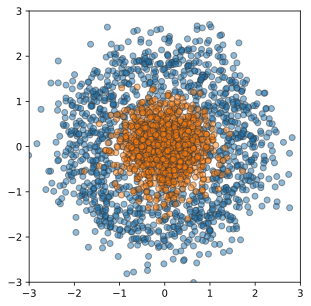

In [6]:
data_noise = 0.25
plotlim = [-3, 3]
subfolder = 'evo_circ'


from models.training import create_dataloader
dataloader, dataloader_viz = create_dataloader('circles', noise = data_noise, plotlim = plotlim)


In [7]:
#We can now conveniently access the data from the dataloaders
for X_test, y_test in dataloader_viz:
    print(X_test[:10], y_test[:10])
    break
    

tensor([[-5.0406e-01,  1.4754e-02],
        [-2.2176e+00, -2.2191e-01],
        [-2.6202e-03, -2.2924e-01],
        [-1.4166e+00, -3.8373e-01],
        [ 3.9139e-02, -3.5560e-01],
        [ 1.1496e+00,  9.3491e-01],
        [ 3.9663e-01, -9.5017e-02],
        [ 7.1716e-01,  1.1677e+00],
        [ 2.6743e+00,  9.9872e-01],
        [-7.0010e-01,  7.9120e-01]]) tensor([1, 0, 1, 1, 1, 0, 1, 1, 0, 0])


# Model dynamics

In [8]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 
augment_dim = 0

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
#!!!!NEW!!!!
T, num_params, num_steps,  = 5, 5, 5 
bound = 0.
fp = False #this recent change made things not work anymore
cross_entropy = True
turnpike = False

non_linearity = 'tanh' #'relu' #
architecture = 'inside' #outside



torch.manual_seed(2)
torch.cuda.manual_seed(2)
anode = NeuralODEvar(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 


print(anode)

NeuralODE(
  (flow): Semiflow(
    (dynamics): Dynamics(
      (non_linearity): Tanh()
      (fc2_time): Sequential(
        (0): Linear(in_features=2, out_features=2, bias=True)
        (1): Linear(in_features=2, out_features=2, bias=True)
        (2): Linear(in_features=2, out_features=2, bias=True)
        (3): Linear(in_features=2, out_features=2, bias=True)
        (4): Linear(in_features=2, out_features=2, bias=True)
        (5): Linear(in_features=2, out_features=2, bias=True)
        (6): Linear(in_features=2, out_features=2, bias=True)
        (7): Linear(in_features=2, out_features=2, bias=True)
        (8): Linear(in_features=2, out_features=2, bias=True)
        (9): Linear(in_features=2, out_features=2, bias=True)
        (10): Linear(in_features=2, out_features=2, bias=True)
        (11): Linear(in_features=2, out_features=2, bias=True)
        (12): Linear(in_features=2, out_features=2, bias=True)
        (13): Linear(in_features=2, out_features=2, bias=True)
        (14

In [9]:
torch.manual_seed(2)
torch.cuda.manual_seed(2)
rnode = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_rnode = torch.optim.Adam(rnode.parameters(), lr=1e-3) 


print(rnode)

NeuralODE(
  (flow): Semiflow(
    (dynamics): Dynamics(
      (non_linearity): Tanh()
      (fc2_time): Sequential(
        (0): Linear(in_features=2, out_features=2, bias=True)
        (1): Linear(in_features=2, out_features=2, bias=True)
        (2): Linear(in_features=2, out_features=2, bias=True)
        (3): Linear(in_features=2, out_features=2, bias=True)
        (4): Linear(in_features=2, out_features=2, bias=True)
        (5): Linear(in_features=2, out_features=2, bias=True)
        (6): Linear(in_features=2, out_features=2, bias=True)
        (7): Linear(in_features=2, out_features=2, bias=True)
        (8): Linear(in_features=2, out_features=2, bias=True)
        (9): Linear(in_features=2, out_features=2, bias=True)
        (10): Linear(in_features=2, out_features=2, bias=True)
        (11): Linear(in_features=2, out_features=2, bias=True)
        (12): Linear(in_features=2, out_features=2, bias=True)
        (13): Linear(in_features=2, out_features=2, bias=True)
        (14

# Training and generating level sets

In [10]:
from models.training import Trainer, doublebackTrainer
import imageio, os
from plots.plots import train_to_classifier_imgs

num_epochs = 120 #number of optimization runs in which the dataset is used for gradient decent
plotfreq = 10


trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = 0, eps_comp = 0.2) 

   
train_to_classifier_imgs(anode, trainer_anode, dataloader, subfolder, num_epochs, plotfreq)


Iteration 0/38
Loss: 0.905
Robust Term Loss: 0.131
Accuracy: 0.328

Iteration 10/38
Loss: 0.758
Robust Term Loss: 0.098
Accuracy: 0.438

Iteration 20/38
Loss: 0.876
Robust Term Loss: 0.109
Accuracy: 0.344

Iteration 30/38
Loss: 0.723
Robust Term Loss: 0.095
Accuracy: 0.453
Epoch 1: 0.840

Iteration 0/38
Loss: 0.790
Robust Term Loss: 0.088
Accuracy: 0.391

Iteration 10/38
Loss: 0.797
Robust Term Loss: 0.086
Accuracy: 0.375

Iteration 20/38
Loss: 0.794
Robust Term Loss: 0.081
Accuracy: 0.422

Iteration 30/38
Loss: 0.652
Robust Term Loss: 0.063
Accuracy: 0.547
Epoch 2: 0.788

Iteration 0/38
Loss: 0.771
Robust Term Loss: 0.068
Accuracy: 0.406

Iteration 10/38
Loss: 0.768
Robust Term Loss: 0.072
Accuracy: 0.359

Iteration 20/38
Loss: 0.812
Robust Term Loss: 0.068
Accuracy: 0.281

Iteration 30/38
Loss: 0.778
Robust Term Loss: 0.065
Accuracy: 0.359
Epoch 3: 0.758

Iteration 0/38
Loss: 0.786
Robust Term Loss: 0.068
Accuracy: 0.359

Iteration 10/38
Loss: 0.715
Robust Term Loss: 0.061
Accuracy:

c:\ProgramData\Anaconda3\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]



 Plot epoch_trained =10

Iteration 0/38
Loss: 0.616
Robust Term Loss: 0.052
Accuracy: 0.750

Iteration 10/38
Loss: 0.600
Robust Term Loss: 0.062
Accuracy: 0.781

Iteration 20/38
Loss: 0.659
Robust Term Loss: 0.059
Accuracy: 0.688

Iteration 30/38
Loss: 0.640
Robust Term Loss: 0.060
Accuracy: 0.750
Epoch 1: 0.629

Iteration 0/38
Loss: 0.620
Robust Term Loss: 0.067
Accuracy: 0.812

Iteration 10/38
Loss: 0.608
Robust Term Loss: 0.066
Accuracy: 0.797

Iteration 20/38
Loss: 0.636
Robust Term Loss: 0.059
Accuracy: 0.781

Iteration 30/38
Loss: 0.591
Robust Term Loss: 0.052
Accuracy: 0.797
Epoch 2: 0.613

Iteration 0/38
Loss: 0.588
Robust Term Loss: 0.062
Accuracy: 0.781

Iteration 10/38
Loss: 0.629
Robust Term Loss: 0.068
Accuracy: 0.719

Iteration 20/38
Loss: 0.583
Robust Term Loss: 0.062
Accuracy: 0.781

Iteration 30/38
Loss: 0.633
Robust Term Loss: 0.086
Accuracy: 0.672
Epoch 3: 0.597

Iteration 0/38
Loss: 0.604
Robust Term Loss: 0.068
Accuracy: 0.766

Iteration 10/38
Loss: 0.596
Robust T

In [11]:
from models.training import Trainer, doublebackTrainer
import imageio, os


trainer_rnode = doublebackTrainer(rnode, optimizer_rnode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = 0.2) 



train_to_classifier_imgs(rnode, trainer_rnode, dataloader, subfolder, num_epochs, plotfreq, filename = 'rob')


Iteration 0/38
Loss: 0.903
Robust Term Loss: 0.135
Accuracy: 0.281

Iteration 10/38
Loss: 0.874
Robust Term Loss: 0.124
Accuracy: 0.312

Iteration 20/38
Loss: 0.724
Robust Term Loss: 0.099
Accuracy: 0.422

Iteration 30/38
Loss: 0.756
Robust Term Loss: 0.096
Accuracy: 0.328
Epoch 1: 0.778

Iteration 0/38
Loss: 0.724
Robust Term Loss: 0.086
Accuracy: 0.438

Iteration 10/38
Loss: 0.707
Robust Term Loss: 0.080
Accuracy: 0.406

Iteration 20/38
Loss: 0.727
Robust Term Loss: 0.078
Accuracy: 0.391

Iteration 30/38
Loss: 0.597
Robust Term Loss: 0.060
Accuracy: 0.562
Epoch 2: 0.703

Iteration 0/38
Loss: 0.681
Robust Term Loss: 0.062
Accuracy: 0.375

Iteration 10/38
Loss: 0.704
Robust Term Loss: 0.060
Accuracy: 0.375

Iteration 20/38
Loss: 0.706
Robust Term Loss: 0.058
Accuracy: 0.312

Iteration 30/38
Loss: 0.681
Robust Term Loss: 0.052
Accuracy: 0.328
Epoch 3: 0.664

Iteration 0/38
Loss: 0.647
Robust Term Loss: 0.049
Accuracy: 0.438

Iteration 10/38
Loss: 0.643
Robust Term Loss: 0.047
Accuracy:

# Loss plots

trainer_rnode.eps = 0.2
epoch = 5


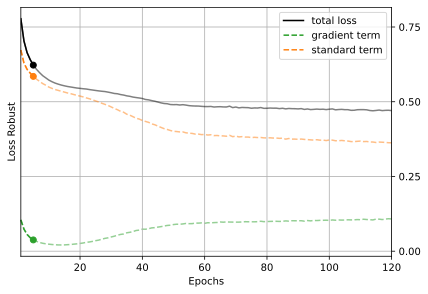

no filename given


In [12]:
from enum import auto

from plots.plots import loss_evolution
print(f'{trainer_rnode.eps = }')
loss_evolution(trainer_rnode, 5)

epoch = 10


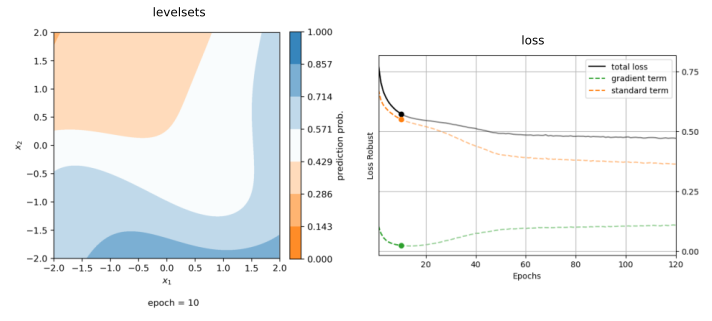

In [13]:
from plots.plots import comparison_plot

epoch = 10
fig_name_base = os.path.join(subfolder, '')
loss_evolution(trainer_rnode, epoch, 'loss_pic')
comparison_plot(fig_name_base + str(epoch) + '.png', 'levelsets', 'loss_pic.png', 'loss', 'test', show = True, figsize = (10,5))

## gif generation

In [14]:
from plots.gifs import evo_gif
gif = evo_gif(trainer_anode, num_epochs, plotfreq, subfolder, '')

10
epoch = 10
20
epoch = 20
30
epoch = 30
40
epoch = 40
50
epoch = 50
60
epoch = 60
70
epoch = 70
80
epoch = 80
90
epoch = 90
100
epoch = 100
110
epoch = 110
120
epoch = 120
evo_circ\evo.gif  created


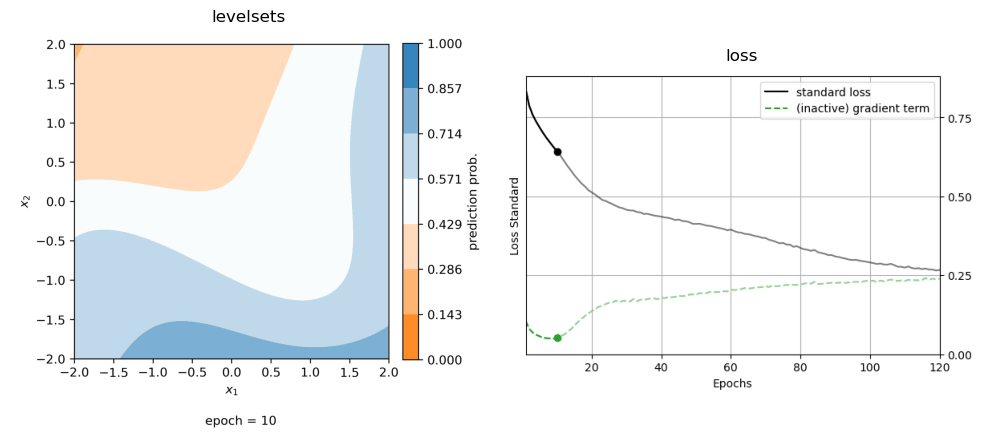

In [15]:
from IPython.display import Image
Image(filename = gif, width = 800)

10
epoch = 10
20
epoch = 20
30
epoch = 30
40
epoch = 40
50
epoch = 50
60
epoch = 60
70
epoch = 70
80
epoch = 80
90
epoch = 90
100
epoch = 100
110
epoch = 110
120
epoch = 120
evo_circ\robevo.gif  created


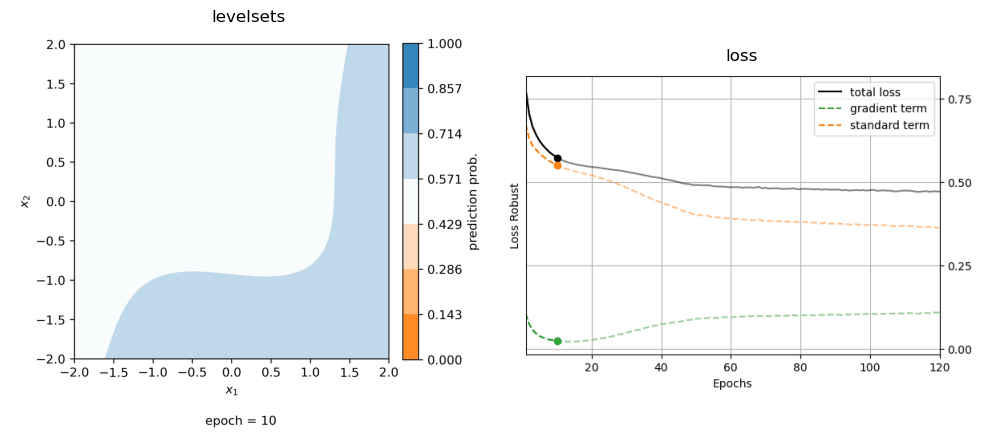

In [16]:
rob_gif = evo_gif(trainer_rnode, num_epochs, plotfreq, subfolder, 'rob')

from IPython.display import Image
Image(filename = rob_gif, width = 800)

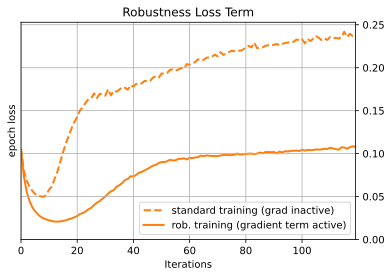

In [17]:
labelsize = 10
plt.plot(trainer_anode.histories['epoch_loss_rob_history'],'--', linewidth = 2, color = 'C1')
plt.title('Robustness Loss Term')
plt.plot(trainer_rnode.histories['epoch_loss_rob_history'], zorder = -1, linewidth = 2, color = 'C1')
plt.xlim(0, len(trainer_rnode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations', size = labelsize)
plt.ylabel('epoch loss', size = labelsize)
plt.legend(['standard training (grad inactive)', 'rob. training (gradient term active)'], prop= {'size': labelsize})
# plt.yticks(np.arange(0,1.25,0.25))
ax = plt.gca()
ax.yaxis.tick_right()
plt.grid()

plt.savefig('loss_comp_grads.png', bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
plt.show()

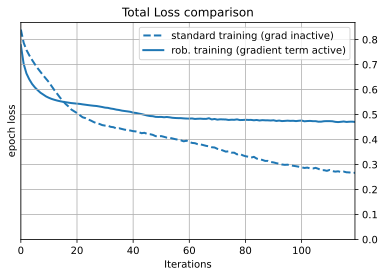

In [18]:
labelsize = 10
plt.plot(trainer_anode.histories['epoch_loss_history'],'--', linewidth = 2, color = 'C0')
plt.title('Total Loss comparison')
plt.plot(trainer_rnode.histories['epoch_loss_history'], zorder = -1, linewidth = 2, color = 'C0')
plt.xlim(0, len(trainer_rnode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations', size = labelsize)
plt.ylabel('epoch loss', size = labelsize)
plt.legend(['standard training (grad inactive)', 'rob. training (gradient term active)'], prop= {'size': labelsize})
# plt.yticks(np.arange(0,1.25,0.25))
ax = plt.gca()
ax.yaxis.tick_right()
plt.grid()

plt.savefig('loss_comp_grads.png', bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
plt.show()

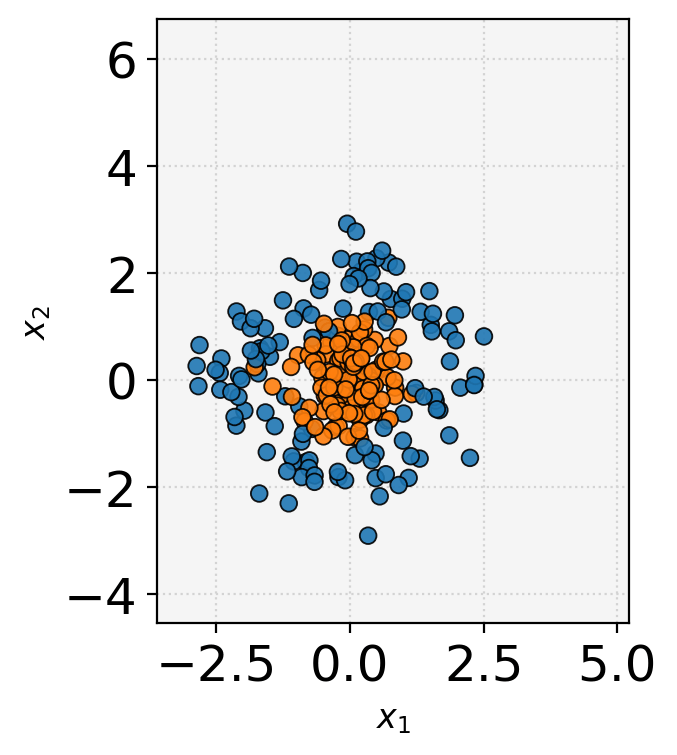

In [19]:
from plots.gifs import trajectory_gif

#the function trajectory_gif creates the evolution trajectories of the input data through the network
#the passing time corresponds to the depth of the network

for X_viz, y_viz in dataloader_viz:
    trajectory_gif(anode, X_viz, y_viz, timesteps=num_steps, filename = 'trajectory.gif')
    break

#Display of the generated gif

from IPython.display import Image
Image(filename="trajectory.gif", retina = True)